# Submission2: Membuat Model Machine Learning dengan Data Time Series

- Nama: Hafiizh Taufiqul Hakim
- Email: 2012500720@student.budiluhur.ac.id
- Id Dicoding: hafizhtaufiqul1002

### Dataset (air-quality-data-in-india)

In [1]:
# Install kaggle
!pip install -q kaggle

In [2]:
# Import file kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hafiizhtaufiqulhakim","key":"b441c5f30c1c72eaf41d95ebbb477fcc"}'}

In [3]:
# Download dataset
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [4]:
!kaggle datasets download -d fedesoriano/air-quality-data-in-india

  0% 0.00/270k [00:00<?, ?B/s]
100% 270k/270k [00:00<00:00, 77.8MB/s]


In [5]:
# Ekstrak dataset
!mkdir air-quality-data-in-india
!unzip air-quality-data-in-india.zip -d air-quality-data-in-india
!ls air-quality-data-in-india

Archive:  air-quality-data-in-india.zip
  inflating: air-quality-data-in-india/air-quality-india.csv  
air-quality-india.csv


### Load Data

In [25]:
import pandas as pd

df = pd.read_csv('/content/air-quality-data-in-india/air-quality-india.csv')

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36192 entries, 0 to 36191
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Timestamp  36192 non-null  object 
 1   Year       36192 non-null  int64  
 2   Month      36192 non-null  int64  
 3   Day        36192 non-null  int64  
 4   Hour       36192 non-null  int64  
 5   PM2.5      36192 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 1.7+ MB


In [27]:
df.head()

,Timestamp,Year,Month,Day,Hour,PM2.5
0,2017-11-07 12:00:00,2017,11,7,12,64.51
1,2017-11-07 13:00:00,2017,11,7,13,69.95
2,2017-11-07 14:00:00,2017,11,7,14,92.79
3,2017-11-07 15:00:00,2017,11,7,15,109.66
4,2017-11-07 16:00:00,2017,11,7,16,116.50


### Preprocessing

In [28]:
df.isnull().sum()

Timestamp    0
Year         0
Month        0
Day          0
Hour         0
PM2.5        0
dtype: int64

In [29]:
df['Timestamp']=pd.to_datetime(df['Timestamp']).dt.date

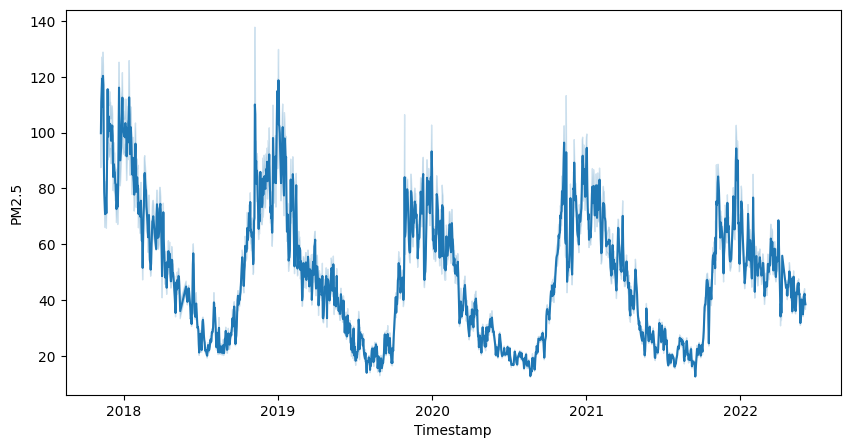

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.lineplot(data=df, x='Timestamp' , y="PM2.5");

plt.show()

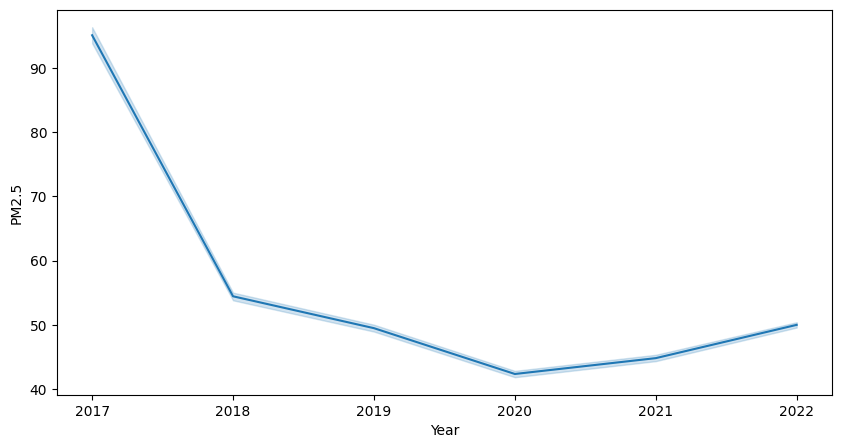

In [31]:
plt.figure(figsize=(10,5))
sns.lineplot(data=df, x='Year', y='PM2.5');

plt.show()

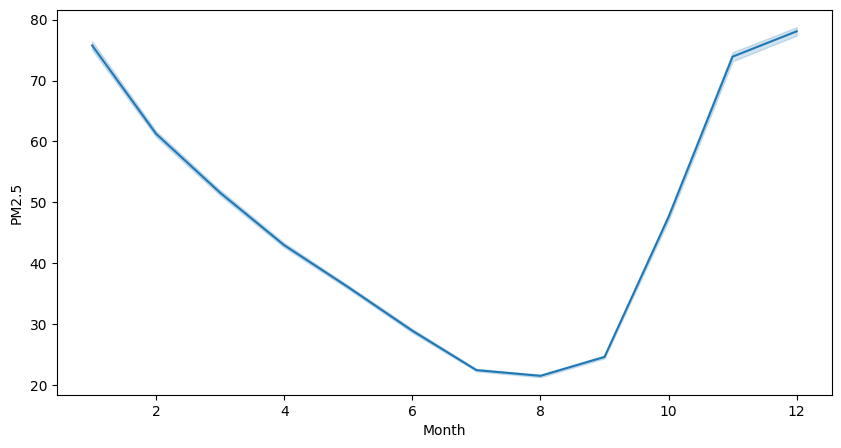

In [32]:
plt.figure(figsize=(10,5))
sns.lineplot(data=df, x='Month', y='PM2.5');

plt.show()

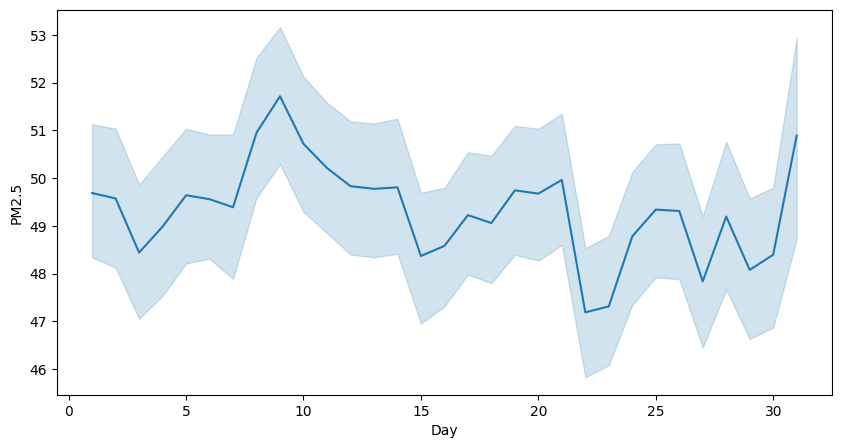

In [33]:
plt.figure(figsize=(10,5))
sns.lineplot(data=df, x='Day', y='PM2.5');

plt.show()

In [54]:
df_new = df[['Timestamp', 'PM2.5']].copy()

In [55]:
df_new['date']=pd.to_datetime(df_new['Timestamp'])

In [56]:
df_new = df_new.drop('Timestamp', axis=1)

In [57]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36192 entries, 0 to 36191
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   PM2.5   36192 non-null  float64       
 1   date    36192 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 565.6 KB


In [59]:
label_values = df_new['PM2.5'].values.reshape(-1, 1)

In [61]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
label_scaled = scaler.fit_transform(label_values)
df_new['normalized_label'] = label_scaled

df_new.head()

,PM2.5,date,normalized_label
0,64.51,2017-11-07,0.240937
1,69.95,2017-11-07,0.263736
2,92.79,2017-11-07,0.359457
3,109.66,2017-11-07,0.430158
4,116.50,2017-11-07,0.458824


### Split Data Training dan Validation

In [62]:
text = df_new['date'].values
label = df_new['normalized_label'].values

In [63]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(text, label, test_size=0.2, shuffle=False)
print(len(x_train), len(x_test))

28953 7239


### Modeling

In [64]:
import tensorflow as tf

def windowed_dataset(series, window_size, batch_size, shuffle_buffer) :
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [85]:
from keras.layers import Dense, LSTM

train_set = windowed_dataset(y_train, window_size = 60, batch_size = 100, shuffle_buffer = 10000)
test_set = windowed_dataset(y_test, window_size = 60, batch_size = 10, shuffle_buffer = 10000)

model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences = True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dense(512, activation = "relu"),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(256, activation="relu"),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(1)
])

In [86]:
max = df_new['normalized_label'].max()
print('Max value : ' )
print(max)

Max value : 
1.0


In [87]:
min = df_new['normalized_label'].min()
print('Min value : ' )
print(min)

Min value : 
0.0


In [88]:
mae = (max - min) * 10/100
print(mae)

0.1


In [89]:
# callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < mae):
      self.model.stop_training = True
      print("\nMAE of the model < 10% of data scale")

callbacks = myCallback()

In [90]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(
    train_set,
    epochs = 100,
    validation_data = test_set,
    callbacks = [callbacks]
  )

Epoch 1/100
289/289 [==============================] - 211s 691ms/step - loss: 0.0143 - mae: 0.1300 - val_loss: 0.0043 - val_mae: 0.0740
Epoch 2/100
289/289 [==============================] - ETA: 0s - loss: 0.0077 - mae: 0.0932
MAE of the model < 10% of data scale
289/289 [==============================] - 198s 679ms/step - loss: 0.0077 - mae: 0.0932 - val_loss: 0.0030 - val_mae: 0.0622


##### Plot of Accuracy

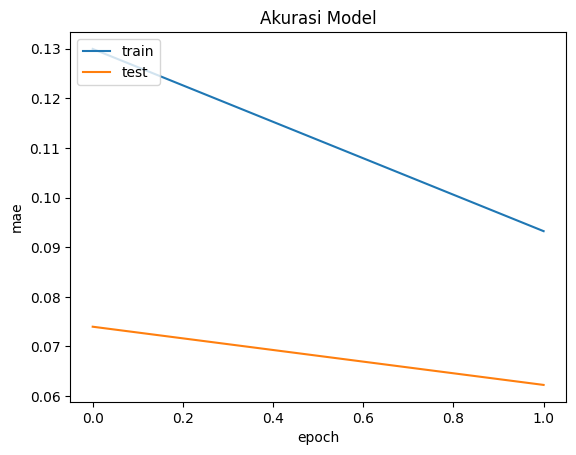

In [96]:
# plot of mae
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Akurasi Model')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##### Plot of Loss

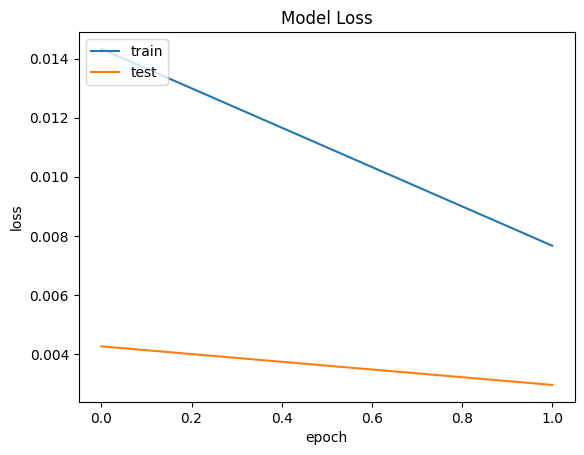

In [95]:
# plot of loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()